In [7]:
#!/usr/bin/env conda run -n datimacchinaenv python
import sys
print(sys.executable)    ### C:\ProgramData\Anaconda3_1\envs\datimacchinaenv\python.exe

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
!jupyter kernelspec list

C:\ProgramData\Anaconda3_1\envs\datimacchinaenv\python.exe


Available kernels:
  python3    C:\ProgramData\Anaconda3_1\envs\datimacchinaenv\share\jupyter\kernels\python3


In [466]:
# !{sys.executable} -m pip install xlwt
# !{sys.executable} -m pip install openpyxl
# !{sys.executable} -m pip install Pillow
# !{sys.executable} -m pip install seaborn
# !conda install --yes --prefix {sys.prefix} xlrd 
# !{sys.executable} -m pip install tables     
# !{sys.executable} -m pip install simpledbf
import sys
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import IPython.display as IPdisplay
import shutil
# per matrice correlazione
import seaborn as sns
# Scipy helper functions
from scipy.stats import percentileofscore
from scipy import stats
import matplotlib.tri as mtri
import datetime as dt
import h5py
import warnings
warnings.filterwarnings('ignore')
from matplotlib.pyplot import figure
import xlwt  # necessario per esportare xls con pandas

### LOAD FILES

In [88]:
path = os.getcwd()+'\\DATA\\20200107'

files = []
filespath = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if r'MERGE' in file:
            files.append(file)
            filespath.append(os.path.join(r, file))
            
# since there is only one file I need only the file name
os.path.join(r, files[0])

print(files)
print(filespath)
df = pd.read_excel(os.path.join(r, files[0]))
print('file loaded'+files[0])
print('\nColumns list:')
print(df.columns.tolist())

['GEODATA_S-1048_RAW_20200107_MERGE.xls']
['C:\\Users\\fpe\\JUPYTER\\datimacchina\\DATA\\20200107\\GEODATA_S-1048_RAW_20200107_MERGE.xls']
file loadedGEODATA_S-1048_RAW_20200107_MERGE.xls

Columns list:
['Date', 'S-1048_ADVANCE_ADVANCE_NO [-]', 'Pressure excavation chamber 1 [bar]', 'Pressure excavation chamber 2 [bar]', 'Pressure excavation chamber 3 [bar]', 'Pressure excavation chamber 4 [bar]', 'Pressure excavation chamber 5 [bar]', 'Pressure excavation chamber 6 [bar]', 'Pressure excavation chamber 7 [bar]', 'Pressure excavation chamber 8 [bar]', 'Line 1 grout injection pressure [bar]', 'Line 1 grout injection flow [l/min]', 'Line 1 grout injection amount [l]', 'Line 2 grout injection pressure [bar]', 'Line 2 grout injection flow [l/min]', 'Line 2 grout injection amount [l]', 'Line 3 grout injection pressure [bar]', 'Line 3 grout injection flow [l/min]', 'Line 3 grout injection amount [l]', 'Line 4 grout injection pressure [bar]', 'Line 4 grout injection flow [l/min]', 'Line 4 grou

### CLEAN DATA AND CREATE NEW COLUMN

In [606]:
#### Drop double columns ending by .1

df.filter(regex='[.]1$')
df = df[df.columns.drop(list(df.filter(regex='[.]1$')))]

###  Create new columns

#### First we create a column that can be detected as date

df['datestamp']=pd.to_datetime(df.Date)
df['timestamp']=df.datestamp.apply(lambda x: int(time.mktime(x.timetuple())))

df.sort_values('timestamp',inplace=True)

#### Then we find the position of relevant indicators  --> do not remove spaces before this 

# cerco la posizione delle colonne principali
 
# regex  --> (?i) means case unsensible

pos_filllev=int(df.columns.get_loc(df.filter(regex='(?i)fill.*lev.*work.*chamb').columns.tolist()[0]))
pos_stroke=int(df.columns.get_loc(df.filter(regex='(?i)aet.*stroke').columns.tolist()[0]))
pos_p01=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)P0.1)(?=.*(?i)Flow)(?=.*(?i)m³/h).*$').columns.tolist()[0]))
pos_p02=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)P0.2)(?=.*(?i)Flow)(?=.*(?i)m³/h).*$').columns.tolist()[0]))
pos_p03=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)P0.3)(?=.*(?i)Flow)(?=.*(?i)m³/h).*$').columns.tolist()[0]))
pos_p04=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)P0.4)(?=.*(?i)Flow)(?=.*(?i)m³/h).*$').columns.tolist()[0]))
pos_p05=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)P0.5)(?=.*(?i)Flow)(?=.*(?i)m³/h).*$').columns.tolist()[0]))
pos_pos02=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)posit)(?=.*(?i)2)(?=.*(?i)m³/h).*$').columns.tolist()[0]))
pos_pos03=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)posit)(?=.*(?i)3)(?=.*(?i)m³/h).*$').columns.tolist()[0]))
pos_advspeed=int(df.columns.get_loc(df.filter(regex='(?i)Advance.*speed.*').columns.tolist()[0]))
pos_torque=int(df.columns.get_loc(df.filter(regex='(?i)torque.*cutting.*wheel.*').columns.tolist()[0]))
pos_feed=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)flow)(?=.*(?i)feed)(?=.*(?i)m³/h).*$').columns.tolist()[0]))
pos_slurry=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)slurry)(?=.*(?i)line)(?=.*(?i)m³/h).*$').columns.tolist()[0]))
pos_num=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)1048)(?=.*(?i)advance)(?=.*(?i)[-]).*$').columns.tolist()[0]))
pos_prch01=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)chamb)(?=.*(?i)1)(?=.*(?i)bar).*$').columns.tolist()[0]))
pos_prch02=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)chamb)(?=.*(?i)2)(?=.*(?i)bar).*$').columns.tolist()[0]))
pos_prch03=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)chamb)(?=.*(?i)3)(?=.*(?i)bar).*$').columns.tolist()[0]))
pos_prch04=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)chamb)(?=.*(?i)4)(?=.*(?i)bar).*$').columns.tolist()[0]))
pos_prch05=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)chamb)(?=.*(?i)5)(?=.*(?i)bar).*$').columns.tolist()[0]))
pos_prch06=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)chamb)(?=.*(?i)6)(?=.*(?i)bar).*$').columns.tolist()[0]))
pos_prch07=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)chamb)(?=.*(?i)7)(?=.*(?i)bar).*$').columns.tolist()[0]))
pos_prch08=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)chamb)(?=.*(?i)8)(?=.*(?i)bar).*$').columns.tolist()[0]))
pos_date=int(df.columns.get_loc(df.filter(regex='datestamp').columns.tolist()[0]))
pos_timestamp=int(df.columns.get_loc(df.filter(regex='timestamp').columns.tolist()[0]))
# densities
pos_dens_p04=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)dens)(?=.*(?i)p04)(?=.*(?i)t/m).*$').columns.tolist()[0]))
pos_dens_slurry=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)dens)(?=.*(?i)slurr)(?=.*(?i)line)(?=.*(?i)t/m³).*$').columns.tolist()[0]))
pos_dens_feed=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)dens)(?=.*(?i)feed)(?=.*(?i)line)(?=.*(?i)t/m³).*$').columns.tolist()[0]))
# stroke cyl abcde
pos_cy_a=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)strok)(?=.*(?i)cyl)(?=.*(?i) A ).*$').columns.tolist()[0]))
pos_cy_b=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)strok)(?=.*(?i)cyl)(?=.*(?i) B ).*$').columns.tolist()[0]))
pos_cy_c=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)strok)(?=.*(?i)cyl)(?=.*(?i) C ).*$').columns.tolist()[0]))
pos_cy_d=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)strok)(?=.*(?i)cyl)(?=.*(?i) D ).*$').columns.tolist()[0]))
pos_cy_e=int(df.columns.get_loc(df.filter(regex='^(?=.*(?i)strok)(?=.*(?i)cyl)(?=.*(?i) E ).*$').columns.tolist()[0]))

col_list=df.columns.tolist()
cl = col_list.copy()  # per chiamare la lista in maniera veloce

In [572]:
# reinitialize the dataframe
dfxls = df.copy()

nw = 0.25 # indice dei vuoti
rho = 2.10 # t/m3 terreno in sito

## We create new columns

#### Datestamp diff (aa-mm-gg hh-mm-ss)
#### Datestamp diff [h]

dfxls['datestamp_p'] = dfxls.datestamp.shift(1).copy()
# Beign the first row == 0 we need to delete it _ but we will do it at the end otherwise we lose data
#dfxls=dfxls.dropna().copy()

dfxls['datestamp_diff']= dfxls['datestamp']-dfxls['datestamp_p']
# dfxls['datestamp_diff2'] = dfxls['datestamp'].diff(periods=1).copy()  # stesso risultato come sopra

dfxls['datestamp_diff[h]'] = dfxls['datestamp_diff'].astype('timedelta64[s]').fillna(0).copy()/3600

#### Differenziali dpressure chambers loop sulle 8 celle di pressione

for i in np.arange(1,9,1):
    dfxls['dpress_ch{}'.format(i)] = dfxls[col_list[pos_prch01+i-1]].diff(periods=1).copy()

#### Creo colonna stroke - delta stroke solo positivi - volumi teorici e volumi teorici cumulati        ['dVol_Teor[m³]']

dfxls['stroke_diff[mm]'] = dfxls[col_list[pos_stroke]].diff(periods=1).fillna(0).copy()
dfxls['stroke_diff_a[mm]'] = dfxls[col_list[pos_cy_a]].diff(periods=1).fillna(0).copy()
dfxls['stroke_diff_b[mm]'] = dfxls[col_list[pos_cy_a]].diff(periods=1).fillna(0).copy()
dfxls['stroke_diff_c[mm]'] = dfxls[col_list[pos_cy_a]].diff(periods=1).fillna(0).copy()
dfxls['stroke_diff_d[mm]'] = dfxls[col_list[pos_cy_a]].diff(periods=1).fillna(0).copy()
dfxls['stroke_diff_e[mm]'] = dfxls[col_list[pos_cy_a]].diff(periods=1).fillna(0).copy()


# creazione indici di movimento
def ff(row):
    
    if row['stroke_diff[mm]']>0 and row['stroke_diff_a[mm]']>0 and row['stroke_diff_b[mm]']>0 and\
       row['stroke_diff_c[mm]']>0 and row['stroke_diff_d[mm]']>0\
     and row['stroke_diff_e[mm]']>0:
        return 1
    else:
        return 0

dfxls['state1'] = dfxls.apply(ff, axis=1)     # 0 se stop 1 se tutti i jack sono in movimento
dfxls['dstroke[mm]'] = dfxls['AET Net Stroke [mm]'].diff(periods=1).fillna(0)
dfxls['state2'] = dfxls['dstroke[mm]'].map(lambda x: 1 if x>0 else 0) # 1 se dstroke avanza 0 se fermo o negativo



#####  Volumi dallo stroke
    
Area_Cutter = 35.59
dfxls['vol_teor_cum[m³]'] = dfxls.iloc[:,pos_stroke]/1000*Area_Cutter
dfxls['vol_teor_cum_dry[m³]'] = dfxls['vol_teor_cum[m³]']*(1-nw)
dfxls['dvol_teor[m³]'] = dfxls['vol_teor_cum[m³]'].diff(periods=1).fillna(0).map(lambda x: 0 if x<0 else x).copy()


#### Calcolo di volumi dal Slurry-Feed * dt           ['dVol_bal_feed_slurry[m³]']

# dfxls['feed_adj[m³/h]'] = dfxls[col_list[pos_feed]]-dfxls[col_list[pos_pos02]]-dfxls[col_list[pos_pos03]]  # incasina non togliere i sensori 2 e 3
# dfxls['bal_feed_slurry[m³/h]']=dfxls[col_list[pos_slurry]]-dfxls['feed_adj[m³/h]']

dfxls['bal_feed_slurry[m³/h]']=dfxls[col_list[pos_slurry]]-dfxls[col_list[pos_feed]]

dfxls['dvol_bal_feed_slurry[m³]']=dfxls['bal_feed_slurry[m³/h]']*dfxls['datestamp_diff[h]']
dfxls['dvol_bal_feed_slurry_cum[m³]']=dfxls['dvol_bal_feed_slurry[m³]'].cumsum().shift(-1).fillna(0)



#### Calcolo di volumi dal Slurry-Feed * dt   METHOD E


dfxls['dvol_calc_MthE[m³]']=(
                            (dfxls[col_list[pos_slurry]]*
                            (dfxls[col_list[pos_dens_slurry]]-1)/(rho-1))-
                            (dfxls[col_list[pos_feed]]*
                            (dfxls[col_list[pos_dens_feed]]-1)/(rho-1))
                            )*dfxls['datestamp_diff[h]']

dfxls['dvol_calc_MthE_cum[m³]']=dfxls['dvol_calc_MthE[m³]'].cumsum().shift(-1).fillna(0)


#### Calcolo volumi dal fill level con formula polinomiale     ['dvol_work_chamb[m³]']

def calcvolume(x):
    vol=-0.113*x**5+0.1236*x**4+0.5462*x**3-0.1059*x**2+5.6112*x+11.794
    if x > 0 : 
        return vol
    elif x < 0 : 
        return vol
    else :
        return 0
    
dfxls['instant_volume[m³]'] = dfxls[col_list[pos_filllev]].map(lambda x: calcvolume(x))
dfxls['dvol_work_chamb[m³]'] = dfxls['instant_volume[m³]'].diff(periods=1).fillna(0).copy()
dfxls['dvol_work_chamb_cum[m³]'] = dfxls['dvol_work_chamb[m³]'].cumsum().shift(-1).fillna(0)

#### Calcolo i balance istantanei e totali

dfxls['dvol_calc[m³]'] = dfxls['dvol_work_chamb[m³]']+dfxls['dvol_bal_feed_slurry[m³]']

dfxls['dvol_teor-calc[m³]'] = dfxls['dvol_teor[m³]']-dfxls['dvol_calc[m³]']





#### Creo la colonna STATE (fulloper,stall_rotating,stall_stand)

dfxls['state']=0
f_min_torq25 = dfxls.iloc[:,pos_torque].describe()[4]
f_min_adv25 = dfxls.iloc[:,pos_advspeed].describe()[4]

dfxls.loc[(dfxls[col_list[pos_torque]]>0) & (dfxls[col_list[pos_advspeed]]>0),'state'] = 'fulloper'
dfxls.loc[(dfxls[col_list[pos_torque]]!=0) & (dfxls[col_list[pos_advspeed]]==0),'state'] = 'stall_rotating'
dfxls.loc[(dfxls[col_list[pos_torque]]==0) & (dfxls[col_list[pos_advspeed]]==0),'state'] = 'stall_stand'

### CREATE col_list for fast individuation of columns

col_list=dfxls.columns.tolist()

col_list[111:]

a = 'datestamp_diff'
a.replace(" ",'').split("[")[0]

ls0 = []
ls1 = []
for i in col_list[111:]:
    
    ls0.append('pos_{}'.format(i.replace(" ",'').split("[")[0]))
    ls1.append(dfxls.columns.get_loc(i))
    
pos_dict = dict(zip(ls0,ls1))   

### Modifiche aggiuntive
- Correggo cambio concio colonna 'num_corr'
- Creo colonna **'change'** False-True quando passo da:
    - fermo( **'dstroke[mm]'** <=0 , **'state2'** =0)
    - in movimento( **'dstroke[mm]'** >0 , **'state2'** =1)
- Creo colonna **change** ovvero quando la macchina si ferma
- Crea colonna **change2** ovvero quando la macchina riparte
- Creo colonna **state3** basata su inizio fine processo
- Creo colonna **num_corr** che è il numero di concio corretto
- Calcolo i volumi cumulati:
    - **'dvol_teor_cum_seg[m³]'**
    - **'dvol_bal_feed_slurry_cum_seg[m³]'**
    - **'dvol_work_chamb_cum_seg[m³]'**
    - **'dvol_calc_cum_seg[m³]'**
    - **'dvol_teor-calc_cum_seg[m³]'**
    - **'dvol_calc_MthE_cum_seg[m³]'**

In [604]:
# creo colonna change in base a 'state2'

dfxls['change'] = dfxls['state2'].gt(dfxls['state2'].shift())
dfxls['change2'] = dfxls['state2'].shift().gt(dfxls['state2'])

dic_start = dfxls[dfxls['change']==True].groupby(col_list[pos_num]).agg({col_list[pos_timestamp]:min}).to_dict()
dic_start = dic_start[list(dic_start.keys())[0]]

dic_end = dfxls[dfxls['change2']==True].groupby(col_list[pos_num]).agg({col_list[pos_timestamp]:max}).to_dict()
dic_end = dic_end[list(dic_end.keys())[0]]


# creo colonna change in base a 'state3'   Inizio fine processo di avanzamento senza tener conto di stop intermedi

def ffstate3(row):
    try:
        if row[col_list[pos_timestamp]]<dic_start[row[col_list[pos_num]]]:
            return 0
    except:
        return 0
    try:
        if row[col_list[pos_timestamp]]>dic_start[row[col_list[pos_num]]]:
            return 1
    except:
        return 0
    try:
        if row[col_list[pos_timestamp]]>dic_end[row[col_list[pos_num]]]:
            return 0
    except:
        return 0

dfxls['state3'] = 0
dfxls['state3'] = dfxls.apply(ffstate3, axis=1)


# creo colonna 'num_corr' 

dfxls.reset_index(drop=True)
for index, row in dfxls.iterrows():
    if index==0: numconcio = dfxls.iloc[0,pos_num]
    dfxls.loc[index,'num_corr'] = numconcio
    if index > 1 and row['dstroke[mm]']==0 and rowp['dstroke[mm]']>0 and row[col_list[pos_stroke]]>1500:
        numconcio += 1
        dfxls.loc[index,'num_corr'] = numconcio
    rowp = row

    
## CALCOLO I VOLUMI CUMULATI     
    
# gr = dfxls[dfxls.state3==1].groupby('num_corr')
gr = dfxls.groupby('num_corr')

dfxls['dvol_teor_cum_seg[m³]'] = gr['dvol_teor[m³]'].cumsum().shift(-1).fillna(0)
dfxls['dvol_bal_feed_slurry_cum_seg[m³]'] = gr['dvol_bal_feed_slurry[m³]'].cumsum().shift(-1).fillna(0)
dfxls['dvol_work_chamb_cum_seg[m³]'] = gr['dvol_work_chamb[m³]'].cumsum().shift(-1).fillna(0)
dfxls['dvol_calc_cum_seg[m³]'] = gr['dvol_calc[m³]'].cumsum().shift(-1).fillna(0)
dfxls['dvol_teor-calc_cum_seg[m³]'] = gr['dvol_teor-calc[m³]'].cumsum().shift(-1).fillna(0)
dfxls['dvol_calc_MthE_cum_seg[m³]'] = gr['dvol_calc_MthE[m³]'].cumsum().shift(-1).fillna(0)


### Lista delle variabili create

In [608]:
# 'vol_teor_cum[m³]'
# 'dvol_teor[m³]'
# 'dvol_bal_feed_slurry[m³]'    
# 'dvol_work_chamb[m³]'
# 'dvol_calc[m³]'
# 'dvol_calc_MthE[m³]'
# 'dvol_teor-calc[m³]'
# 'dvol_teor_cum_seg[m³]'
# 'dvol_bal_feed_slurry_cum_seg[m³]'
# 'dvol_work_chamb_cum_seg[m³]'
# 'dvol_calc_cum_seg[m³]'
# 'dvol_teor-calc_cum_seg[m³]'
# 'dvol_calc_MthE_cum_seg[m³]'

In [474]:
dftemp =dfxls[dfxls['num_corr']==4205][[col_list[pos_stroke],col_list[pos_filllev],col_list[pos_slurry],col_list[pos_feed],col_list[pos_dens_feed],col_list[pos_dens_slurry]]]
dftemp.to_excel('dftemp.xls')

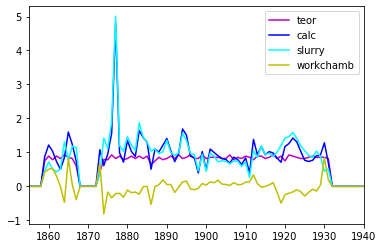

In [430]:
plt.figure()
(dfxls['dvol_teor[m³]']*dfxls['state2']).plot(c='m',label='teor')
(dfxls['dvol_calc[m³]']*dfxls['state2']).plot(c='b',label='calc')
(dfxls['dvol_bal_feed_slurry[m³]']*dfxls['state2']).plot(c='cyan',label='slurry')
(dfxls['dvol_work_chamb[m³]']*dfxls['state2']).plot(c='y',label='workchamb')

plt.xlim(1855,1940)
plt.legend()

In [238]:
dfreduced=dfxls.loc[:,[col_list[pos_num],col_list[pos_feed],col_list[pos_slurry],col_list[pos_filllev],'dvol_bal_feed_slurry[m³]','dvol_work_chamb[m³]','dvol_teor[m³]','dvol_calc[m³]','dvol_teor-calc[m³]']]

In [239]:
dfreduced.groupby(col_list[pos_num]).agg(np.average)

,Flow feed line [m³/h],Flow slurry line [m³/h],Fill level working chamber [m],dvol_bal_feed_slurry[m³],dvol_work_chamb[m³],dvol_teor[m³],dvol_calc[m³],dvol_teor-calc[m³]
S-1048_ADVANCE_ADVANCE_NO [-],,,,,,,,
4201,445.576182,485.967922,0.600130,0.336598,0.019335,0.259140,0.355933,-0.096793
4202,937.706839,997.494151,0.599995,0.498228,-0.004388,0.328651,0.493839,-0.165188
4203,896.246789,945.491432,0.564637,0.410372,0.011195,0.295210,0.421568,-0.126358
4204,273.703806,294.288308,0.523942,0.171538,-0.007851,0.128105,0.163687,-0.035582
4205,119.339317,129.672903,0.550027,0.086113,0.000219,0.066980,0.086333,-0.019352
4206,274.896902,297.759495,0.416213,0.190522,0.000260,0.134953,0.190781,-0.055829
4207,73.510305,74.056947,0.509025,0.004555,-0.001086,0.000000,0.003470,-0.003470


In [ ]:
dfxls.loc[:,[col_list[pos_num],col_list[pos_feed],col_list[pos_slurry],col_list[pos_filllev],'dvol_bal_feed_slurry[m³]','dvol_work_chamb[m³]','dvol_teor[m³]','dvol_calc[m³]','dvol_teor-calc[m³]']]

In [514]:
dfxls[dfxls['change2']==True][[col_list[pos_stroke],col_list[pos_num],'change2','change']]

,AET Net Stroke [mm],S-1048_ADVANCE_ADVANCE_NO [-],change2,change
199,1587,4202,True,False
369,1612,4202,True,False
566,1588,4203,True,False
962,1618,4205,True,False
1868,214,4205,True,False
1932,1601,4205,True,False
2349,1601,4206,True,False


In [515]:
dfxls[dfxls['change']==True].groupby(col_list[pos_num]).agg({col_list[pos_stroke]:min})

,AET Net Stroke [mm]
S-1048_ADVANCE_ADVANCE_NO [-],
4201,38
4202,38
4203,38
4204,25
4205,29
4206,40


S-1048_ADVANCE_ADVANCE_NO [-]
4201    AxesSubplot(0.125,0.125;0.775x0.755)
4202    AxesSubplot(0.125,0.125;0.775x0.755)
4203    AxesSubplot(0.125,0.125;0.775x0.755)
4204    AxesSubplot(0.125,0.125;0.775x0.755)
4205    AxesSubplot(0.125,0.125;0.775x0.755)
4206    AxesSubplot(0.125,0.125;0.775x0.755)
4207    AxesSubplot(0.125,0.125;0.775x0.755)
Name: AET Net Stroke [mm], dtype: object

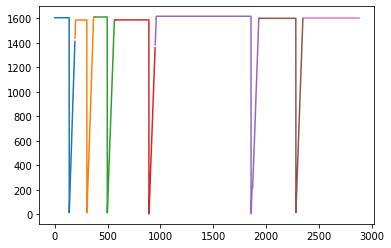

In [345]:
dfxls.groupby(col_list[pos_num])[col_list[pos_stroke]].plot()

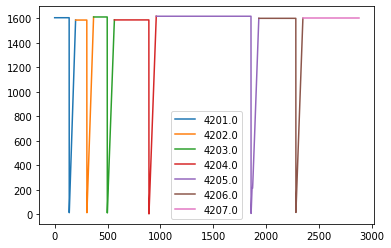

In [575]:
dfxls.groupby('num_corr')[col_list[pos_stroke]].plot()
plt.legend()

In [ ]:
# prima metti a posto il numero di anello

In [ ]:
# used_g = df.groupby('user')['used']
# df['new'] = used_g.cumcount() - used_g.transform(lambda x: (x.values).argmax())

In [409]:
dfxls['dvol_bal_feed_slurry_cum_seg[m³]'] = gr.cumsum().shift(-1).fillna(0)

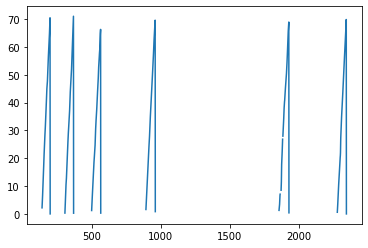

In [410]:
dfxls['dvol_bal_feed_slurry_cum_seg[m³]'].plot()

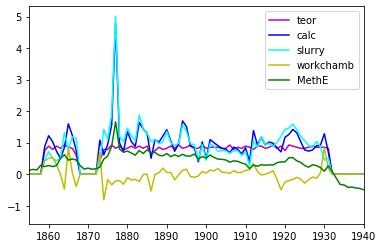

In [473]:
plt.figure()
(dfxls['dvol_teor[m³]']*dfxls['state2']).plot(c='m',label='teor')
(dfxls['dvol_calc[m³]']*dfxls['state2']).plot(c='b',label='calc')
(dfxls['dvol_bal_feed_slurry[m³]']*dfxls['state2']).plot(c='cyan',label='slurry')
(dfxls['dvol_work_chamb[m³]']*dfxls['state2']).plot(c='y',label='workchamb')
(dfxls['dvol_calc_MthE[m³]']).plot(c='g',label='MethE')
plt.xlim(1855,1940)
plt.legend()

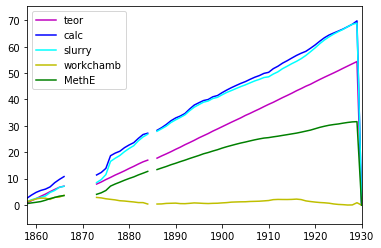

In [472]:
plt.figure()
(dfxls['dvol_teor_cum_seg[m³]']).plot(c='m',label='teor')
(dfxls['dvol_calc_cum_seg[m³]']).plot(c='b',label='calc')
(dfxls['dvol_bal_feed_slurry_cum_seg[m³]']).plot(c='cyan',label='slurry')
(dfxls['dvol_work_chamb_cum_seg[m³]']).plot(c='y',label='workchamb')
(dfxls['dvol_calc_MthE_cum_seg[m³]']).plot(c='g',label='MethE')
plt.xlim(1858,1930)
plt.legend()

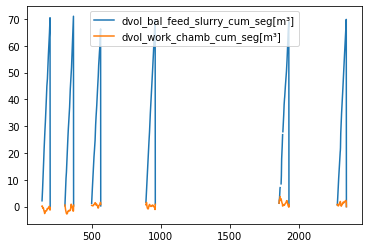

In [427]:
# 'vol_teor_cum[m³]'
# #
# 'dvol_teor[m³]'
# 'dvol_bal_feed_slurry[m³]'    
# 'dvol_work_chamb[m³]'
# #
# 'dvol_calc[m³]'
# 'dvol_teor-calc[m³]'


# dfxls['dvol_teor_cum_seg[m³]'].plot()
dfxls['dvol_bal_feed_slurry_cum_seg[m³]'].plot()
dfxls['dvol_work_chamb_cum_seg[m³]'].plot()
# dfxls['dvol_calc_cum_seg[m³]'].plot()
# dfxls['dvol_teor-calc_cum_seg[m³]'].plot()

plt.legend()

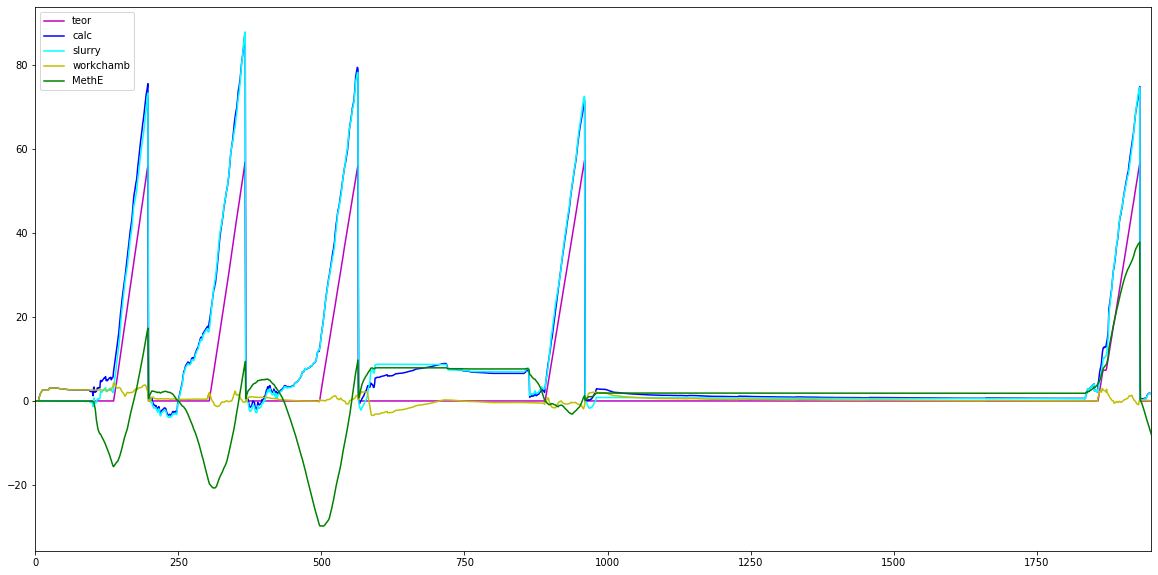

In [612]:
plt.figure(figsize=(20,10))
(dfxls['dvol_teor_cum_seg[m³]']).plot(c='m',label='teor')
(dfxls['dvol_calc_cum_seg[m³]']).plot(c='b',label='calc')
(dfxls['dvol_bal_feed_slurry_cum_seg[m³]']).plot(c='cyan',label='slurry')
(dfxls['dvol_work_chamb_cum_seg[m³]']).plot(c='y',label='workchamb')
(dfxls['dvol_calc_MthE_cum_seg[m³]']).plot(c='g',label='MethE')
# plt.xlim(1858,1930)
plt.xlim(0,1950)
plt.legend()

In [615]:
dfxls[dfxls.num_corr==4205][[cl[pos_stroke],cl[pos_stroke],cl[pos_num],cl[pos_filllev],cl[pos_feed],cl[pos_slurry],'dvol_calc_cum_seg[m³]','dvol_teor_cum_seg[m³]','dvol_calc_MthE_cum_seg[m³]']]

,AET Net Stroke [mm],AET Net Stroke [mm],S-1048_ADVANCE_ADVANCE_NO [-],Fill level working chamber [m],Flow feed line [m³/h],Flow slurry line [m³/h],dvol_calc_cum_seg[m³],dvol_teor_cum_seg[m³],dvol_calc_MthE_cum_seg[m³]
962,1618,1618,4205,0.512,1017.506,1005.281,0.151774,0.00000,0.281110
963,1618,1618,4205,0.553,997.179,979.601,0.214046,0.00000,0.457913
964,1618,1618,4205,0.569,1008.319,1004.196,0.223081,0.00000,0.601315
965,1618,1618,4205,0.615,1029.297,996.745,0.058369,0.00000,0.752806
966,1618,1618,4205,0.662,1054.326,999.711,0.155094,0.00000,0.900020
...,...,...,...,...,...,...,...,...,...
1927,1506,1506,4205,0.358,979.456,1081.597,72.075261,54.16798,37.321123
1928,1530,1530,4205,0.334,959.201,1083.623,72.991611,55.02214,37.529453
1929,1554,1554,4205,0.340,970.341,1076.172,74.273237,55.87630,37.622132
1930,1578,1578,4205,0.484,961.733,1014.902,74.971002,56.69487,37.889374


In [ ]:
# 'vol_teor_cum[m³]'
# 'dvol_teor[m³]'
# 'dvol_bal_feed_slurry[m³]'    
# 'dvol_work_chamb[m³]'
# 'dvol_calc[m³]'
# 'dvol_calc_MthE[m³]'
# 'dvol_teor-calc[m³]'
# 'dvol_teor_cum_seg[m³]'
# 'dvol_bal_feed_slurry_cum_seg[m³]'
# 'dvol_work_chamb_cum_seg[m³]'
# 'dvol_calc_cum_seg[m³]'
# 'dvol_teor-calc_cum_seg[m³]'
# 'dvol_calc_MthE_cum_seg[m³]'